# State tomography
State tomography involves measuring a quantum state repeatedly in the bases given by `itertools.product(['X', 'Y', 'Z], repeat=n_qubits)`. From these measurements, we can reconstruct a density matrix $\rho$.

In [1]:
import numpy as np
from pyquil import Program, get_qc
from pyquil.gates import *

## Construct a state with a `Program`
We'll construct a two-qubit graph state by Hadamarding all qubits and then applying a controlled-Z operation across edges of our graph. In the two-qubit case, there's only one edge. 

In [2]:
qubits = [0, 1]
program = Program()
for qubit in qubits:
    program += H(qubit)
program += CZ(qubits[0], qubits[1])
print(program)

H 0
H 1
CZ 0 1



## Construct a `TomographyExperiment` for state tomography
We can print this out to see the 16 measurements we will perform.

In [3]:
from forest.benchmarking.tomography import generate_state_tomography_experiment
experiment = generate_state_tomography_experiment(program=program, qubits=qubits)
print(experiment)

H 0; H 1; CZ 0 1
0: Z0_0 * Z0_1→(1+0j)*I
1: Z0_0 * Z0_1→(1+0j)*X1
2: Z0_0 * Z0_1→(1+0j)*Y1
3: Z0_0 * Z0_1→(1+0j)*Z1
4: Z0_0 * Z0_1→(1+0j)*X0
5: Z0_0 * Z0_1→(1+0j)*X0X1
6: Z0_0 * Z0_1→(1+0j)*X0Y1
7: Z0_0 * Z0_1→(1+0j)*X0Z1
8: Z0_0 * Z0_1→(1+0j)*Y0
9: Z0_0 * Z0_1→(1+0j)*Y0X1
10: Z0_0 * Z0_1→(1+0j)*Y0Y1
11: Z0_0 * Z0_1→(1+0j)*Y0Z1
12: Z0_0 * Z0_1→(1+0j)*Z0
13: Z0_0 * Z0_1→(1+0j)*Z0X1
14: Z0_0 * Z0_1→(1+0j)*Z0Y1
15: Z0_0 * Z0_1→(1+0j)*Z0Z1


### Optional grouping
We can simultaneously estimate some of these observables

In [4]:
from pyquil.operator_estimation import group_experiments
print(group_experiments(experiment))

H 0; H 1; CZ 0 1
0: Z0_0 * Z0_1→(1+0j)*I, Z0_0 * Z0_1→(1+0j)*X1, Z0_0 * Z0_1→(1+0j)*X0, Z0_0 * Z0_1→(1+0j)*X0X1
1: Z0_0 * Z0_1→(1+0j)*Y1, Z0_0 * Z0_1→(1+0j)*X0Y1
2: Z0_0 * Z0_1→(1+0j)*Z1, Z0_0 * Z0_1→(1+0j)*X0Z1
3: Z0_0 * Z0_1→(1+0j)*Y0, Z0_0 * Z0_1→(1+0j)*Y0X1
4: Z0_0 * Z0_1→(1+0j)*Y0Y1
5: Z0_0 * Z0_1→(1+0j)*Y0Z1
6: Z0_0 * Z0_1→(1+0j)*Z0, Z0_0 * Z0_1→(1+0j)*Z0X1
7: Z0_0 * Z0_1→(1+0j)*Z0Y1
8: Z0_0 * Z0_1→(1+0j)*Z0Z1


## PyQuil will run the tomography programs

In [5]:
from pyquil.operator_estimation import measure_observables

qc = get_qc('2q-qvm')
# Over-write full quilc compilation with a much more simple
# version that *only* substitutes gates to Rigetti-native gates.
# We don't want to accidentally compile away our tomography circuit
# or map to different qubits.
from forest.benchmarking.compilation import basic_compile
qc.compiler.quil_to_native_quil = basic_compile

results = list(measure_observables(qc=qc, tomo_experiment=experiment, n_shots=1_000))
results

[ExperimentResult[Z0_0 * Z0_1→(1+0j)*I: 1.0 +- 0.0],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X1: 0.006 +- 0.03162220738658198],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y1: -0.036 +- 0.03160227839887498],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z1: 0.034 +- 0.03160449335142078],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0: -0.046 +- 0.03158930198659034],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0X1: 0.06 +- 0.031565804282482644],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0Y1: -0.036 +- 0.03160227839887498],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*X0Z1: 1.0 +- 0.0],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0: 0.092 +- 0.0314886646271321],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0X1: 0.01 +- 0.03162119542332326],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0Y1: 1.0 +- 0.0],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Y0Z1: -0.006 +- 0.031622207386581974],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z0: 0.03 +- 0.031608543148965274],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z0X1: 1.0 +- 0.0],
 ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z0Y1: 0.0 +

### We can look at a bunch of numbers...

In [6]:
from forest.benchmarking.tomography import linear_inv_state_estimate, no_inverse
rho = linear_inv_state_estimate(results, qubits=qubits)
rhoprime = no_inverse(results, qubits)
np.round(rho, 3)

array([[ 0.266+0.j   ,  0.239-0.021j,  0.251+0.009j, -0.235+0.007j],
       [ 0.238+0.022j,  0.251-0.j   ,  0.265+0.011j, -0.248+0.009j],
       [ 0.252-0.009j,  0.265-0.012j,  0.249-0.j   , -0.262-0.024j],
       [-0.235-0.006j, -0.248-0.009j, -0.262+0.024j,  0.234-0.j   ]])

In [7]:
np.round(rhoprime, 3)

array([[ 0.266+0.j   ,  0.238-0.022j,  0.252+0.009j, -0.235+0.006j],
       [ 0.238+0.022j,  0.251+0.j   ,  0.265+0.012j, -0.248+0.009j],
       [ 0.252-0.009j,  0.265-0.012j,  0.249+0.j   , -0.262-0.024j],
       [-0.235-0.006j, -0.248-0.009j, -0.262+0.024j,  0.234+0.j   ]])

In [8]:
psi = (1/2) * np.array([1, 1, 1, -1])
rho_true = np.outer(psi, psi.T.conj())
rho_true

array([[ 0.25,  0.25,  0.25, -0.25],
       [ 0.25,  0.25,  0.25, -0.25],
       [ 0.25,  0.25,  0.25, -0.25],
       [-0.25, -0.25, -0.25,  0.25]])

### Or visualize using Hinton plots

In [9]:
from matplotlib import pyplot as plt
from forest.benchmarking.plotting import hinton
fig, (ax1, ax2) = plt.subplots(1, 2)
hinton(rho_true, ax=ax1)
hinton(rho, ax=ax2)
ax1.set_title('Analytical')
ax2.set_title('Estimated')
fig.tight_layout()

### Matrix norm between true and estimated is low

In [10]:
np.linalg.norm(rho - rho_true)

0.06892024376045101

## Linear inversion estimate

[[ 0.266 +0.j      0.2385-0.0215j  0.2515+0.009j  -0.235 +0.0065j]
 [ 0.2385+0.0215j  0.251 -0.j      0.265 +0.0115j -0.2485+0.009j ]
 [ 0.2515-0.009j   0.265 -0.0115j  0.249 -0.j     -0.2615-0.0245j]
 [-0.235 -0.0065j -0.2485-0.009j  -0.2615+0.0245j  0.234 -0.j    ]]
Purity = (1.00475-2.2985086056692694e-16j)


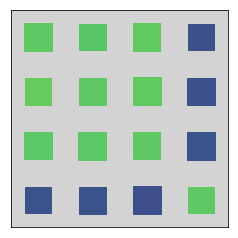

In [11]:
from forest.benchmarking.tomography import linear_inv_state_estimate
rho = linear_inv_state_estimate(results, qubits=qubits)

print(np.round(rho, 4))
print('Purity =', np.trace(rho @ rho))
hinton(rho)

## Maximum Liklihood Estimate (MLE) via diluted iterative method

[[ 0.247 +0.j      0.2489-0.0072j  0.2529-0.0039j -0.245 +0.0016j]
 [ 0.2489+0.0072j  0.2511-0.j      0.2549+0.0035j -0.247 -0.0055j]
 [ 0.2529+0.0039j  0.2549-0.0035j  0.2589+0.j     -0.2508-0.0022j]
 [-0.245 -0.0016j -0.247 +0.0055j -0.2508+0.0022j  0.243 -0.j    ]]
Purity = (0.9999999336158976+2.3635607360183997e-17j)


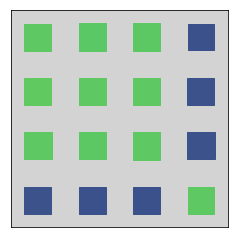

In [12]:
from forest.benchmarking.tomography import iterative_mle_state_estimate
rho = iterative_mle_state_estimate(results=results, qubits=qubits)
print(np.around(rho, decimals=4))
print('Purity =', np.trace(rho @ rho))
hinton(rho)

## MLE with Max Entropy constraint

[[ 0.247 +0.j      0.2489-0.0072j  0.2529-0.0039j -0.245 +0.0016j]
 [ 0.2489+0.0072j  0.2511-0.j      0.2549+0.0035j -0.247 -0.0055j]
 [ 0.2529+0.0039j  0.2549-0.0035j  0.2589+0.j     -0.2508-0.0022j]
 [-0.245 -0.0016j -0.247 +0.0055j -0.2508+0.0022j  0.243 -0.j    ]]
Purity = (0.9999999448216077+1.734723475976807e-18j)


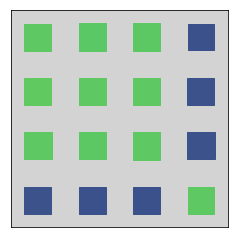

In [13]:
rho = iterative_mle_state_estimate(results=results, qubits=qubits, epsilon=0.5, entropy_penalty=0.005)
print(np.around(rho, decimals=4))
print('Purity =', np.trace(rho @ rho))
hinton(rho)

## MLE with Hedging parameter

[[ 0.247 +0.j      0.2486-0.0072j  0.2525-0.0039j -0.2447+0.0016j]
 [ 0.2486+0.0072j  0.2511-0.j      0.2546+0.0035j -0.2467-0.0055j]
 [ 0.2525+0.0039j  0.2546-0.0035j  0.2589+0.j     -0.2505-0.0022j]
 [-0.2447-0.0016j -0.2467+0.0055j -0.2505+0.0022j  0.243 -0.j    ]]
Purity =  (0.9981650861563647+5.421010862427522e-19j)


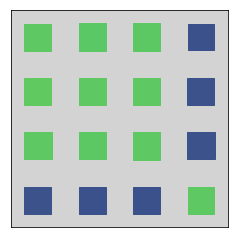

In [14]:
rho = iterative_mle_state_estimate(results=results, qubits=qubits, epsilon=.0001, beta=.61)
print(np.around(rho, decimals=4))
print('Purity = ', np.trace(rho @ rho))
hinton(rho)

## Project an unphysical state to the closest physical state

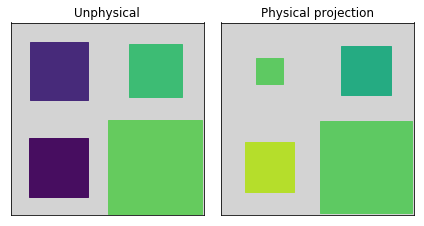

In [15]:
from forest.benchmarking.tomography import project_density_matrix
rho_unphys = np.random.uniform(-1, 1, (2, 2)) \
    * np.exp(1.j * np.random.uniform(-np.pi, np.pi, (2, 2)))
rho_phys = project_density_matrix(rho_unphys)

fig, (ax1, ax2) = plt.subplots(1, 2)
hinton(rho_unphys, ax=ax1)
hinton(rho_phys, ax=ax2)
ax1.set_title('Unphysical')
ax2.set_title('Physical projection')
fig.tight_layout()

In [16]:
# Test the wizard method. Example from fig 1 of maximum likelihood minimum effort 
# https://doi.org/10.1103/PhysRevLett.108.070502

eigs = np.diag(np.array(list(reversed([3.0/5, 1.0/2, 7.0/20, 1.0/10, -11.0/20]))))
phys = project_density_matrix(eigs)
np.allclose(phys, np.diag([0, 0, 1.0/5, 7.0/20, 9.0/20]))

True

# Lightweight Bootstrap for functionals of the state

In [17]:
import forest.benchmarking.distance_measures as dm
from forest.benchmarking.tomography import estimate_variance

In [18]:
from functools import partial
fast_tomo_est = partial(iterative_mle_state_estimate, epsilon=.0001, beta=.5, tol=1e-3)

**Purity**

In [19]:
mle_est = estimate_variance(results, qubits, fast_tomo_est, dm.purity,
                            n_resamples=40, project_to_physical=True)
lin_inv_est = estimate_variance(results, qubits, linear_inv_state_estimate, dm.purity,
                                n_resamples=40, project_to_physical=True)
print(mle_est)
print(lin_inv_est)

(0.988715690502534, 2.9362052295244597e-06)
(0.9537260899779951, 0.00011259121314403501)


**Fidelity**

In [20]:
mle_est = estimate_variance(results, qubits, fast_tomo_est, dm.fidelity,
                            target_state=rho_true, n_resamples=40, project_to_physical=True)
lin_inv_est = estimate_variance(results, qubits, linear_inv_state_estimate, dm.fidelity,
                                target_state=rho_true, n_resamples=40, project_to_physical=True)
print(mle_est)
print(lin_inv_est)

Matrix is singular and may not have a square root.
Matrix is singular and may not have a square root.


ValueError: array must not contain infs or NaNs